In [1]:
import h5py
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import os
import datetime
import time

In [2]:
np.random.seed(1619)

In [3]:
source_file = h5py.File('/work/ka1176/shared_data/2020-03/dev_data/dev_data_random_all_map/train_data.h5', 'r')

In [4]:
timestamp = source_file['ddm_timestamp_unix'][:]

In [5]:
windspeed = source_file['windspeed'][:]

In [6]:
daystamp = ((timestamp - timestamp[0]) / 24 / 3600).astype(int)

In [7]:
uvals, ucnts = np.unique(daystamp, return_counts=True)

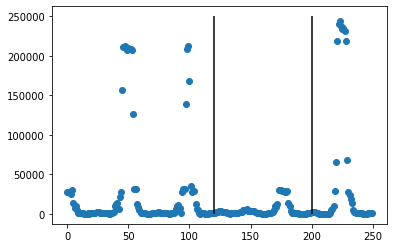

In [8]:
plt.scatter(uvals, ucnts)
plt.vlines(120, 0, 250000)
plt.vlines(200, 0, 250000)

Target data set sizes:
    - 60,000 samples for training
    - 10,000 samples for validation
    - 10,000 samples for testing

In [9]:
ix_train = np.random.choice(np.sum(daystamp<120), size=60000, replace=False)
ix_valid = np.random.choice(np.sum((daystamp>=120) & (daystamp<200)), size=10000, replace=False) + np.sum(daystamp<120)
ix_test  = np.random.choice(np.sum(daystamp>=200), size=10000, replace=False) + np.sum(daystamp<200)

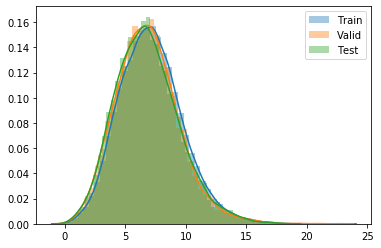

In [10]:
sns.distplot(windspeed[ix_train], label='Train')
sns.distplot(windspeed[ix_valid], label='Valid')
sns.distplot(windspeed[ix_test], label='Test')
plt.legend()
plt.show()

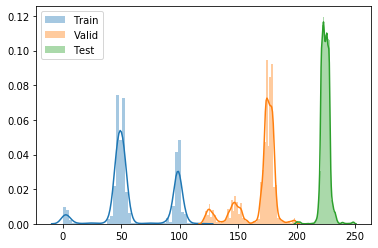

In [11]:
sns.distplot(daystamp[ix_train], label='Train')
sns.distplot(daystamp[ix_valid], label='Valid')
sns.distplot(daystamp[ix_test], label='Test')
plt.legend()
plt.show()

Variables in the new data set
- brcs (17 x 11 map)
- eff_scatter (17 x 11 map)
- quality (bool: select)
- windspeed (target)
- ddm_nbrcs (for the linear regression)

In [12]:
## Load all features and targets
train_dataset = dict()
valid_dataset = dict()
test_dataset = dict()

brcs = source_file['brcs'][:]
train_dataset['brcs'] = brcs[ix_train]
valid_dataset['brcs'] = brcs[ix_valid]
test_dataset['brcs'] = brcs[ix_test]
del brcs

eff_scatter = source_file['eff_scatter'][:]
train_dataset['eff_scatter'] = eff_scatter[ix_train]
valid_dataset['eff_scatter'] = eff_scatter[ix_valid]
test_dataset['eff_scatter'] = eff_scatter[ix_test]
del eff_scatter

quality = source_file['ddm_nbrcs_exceeds_alpha_0.975'][:].astype(bool) & ~source_file['ddm_nbrcs_exceeds_alpha_0.025'][:].astype(bool)
train_dataset['quality'] = quality[ix_train]
valid_dataset['quality'] = quality[ix_valid]
test_dataset['quality'] = quality[ix_test]

ddm_nbrcs = source_file['ddm_nbrcs'][:]
train_dataset['ddm_nbrcs'] = ddm_nbrcs[ix_train]
valid_dataset['ddm_nbrcs'] = ddm_nbrcs[ix_valid]
test_dataset['ddm_nbrcs'] = ddm_nbrcs[ix_test]

windspeed = source_file['windspeed'][:]
train_dataset['windspeed'] = windspeed[ix_train]
valid_dataset['windspeed'] = windspeed[ix_valid]
test_dataset['windspeed'] = windspeed[ix_test]


In [16]:
dtypes=dict(quality='bool', windspeed='float32', ddm_nbrcs='float32')

In [17]:
def save_dataset(dataset, h5_file_name):
    if os.path.exists(h5_file_name):
        os.remove(h5_file_name)
        print('cleared', h5_file_name)
    h5_file = h5py.File(h5_file_name, 'w')
    image_dims = dataset['brcs'][0].shape
    n_samples = len(dataset['windspeed'])
    if n_samples > 0:
        for key in dataset.keys():
            chunk_size = 1000 if n_samples >= 1000 else n_samples
            if key in ['brcs', 'eff_scatter']:
                h5_file.create_dataset(key,
                                       shape=(n_samples,) + image_dims,
                                       chunks=(chunk_size,) + image_dims,
                                       fletcher32=True,
                                       dtype='float32')
            else:
                h5_file.create_dataset(key,
                                       shape=(n_samples,),
                                       chunks=(chunk_size,),
                                       fletcher32=True,
                                       dtype=dtypes[key])
            h5_file[key][:] = dataset[key]
            h5_file.flush()
    h5_file.attrs['timestamp'] = str(datetime.datetime.now())
    h5_file.close()



In [18]:
## Save to three *.h5 files
save_dataset(train_dataset, './data_regression_cygnss/train_data.h5')
save_dataset(valid_dataset, './data_regression_cygnss/valid_data.h5')
save_dataset(test_dataset, './data_regression_cygnss/test_data.h5')

cleared ./data_regression_cygnss/train_data.h5
cleared ./data_regression_cygnss/valid_data.h5
cleared ./data_regression_cygnss/test_data.h5
